In [1]:
# Import Basic Packages
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)

# Import Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib_venn import venn2

# Import NLP Packages
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

# Import sklearn Packages
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('reddit_clean.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11312 entries, 0 to 11311
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    11312 non-null  object
 1   title        11312 non-null  object
 2   selftext     11312 non-null  object
 3   created_utc  11312 non-null  int64 
 4   word_count   11312 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 442.0+ KB


In [4]:
df.isnull().sum()

subreddit      0
title          0
selftext       0
created_utc    0
word_count     0
dtype: int64

In [5]:
df['subreddit'].value_counts(normalize=True)

investing         0.5
wallstreetbets    0.5
Name: subreddit, dtype: float64

## Preprocessing

In [6]:
df.head()

,subreddit,title,selftext,created_utc,word_count
0,investing,Why has SCHB been outperforming SWTSX a little...,"SCHB is a US broad market ETF, and SWTSX is a ...",1608335085,103
1,investing,Is Lithium Overpriced? Is anything cheap?,I have been wanting to get into lithium for a ...,1608335945,67
2,investing,"Favorite ""Game Changer"" Technology Picks?","If QS can get solid-state to ""work"" (a big que...",1608338046,92
3,investing,BFT: Juicy looking Acquisition,"Hey Guys, for once I've done some actual DD an...",1608339518,130
4,investing,Tesla Shares Hit Record After Last-Minute Surg...,&gt;Tesla Inc. shares roared to a record high ...,1608340295,218


In [7]:
# Combining selftext and title columns
df['text'] = df['title'] + ' ' + df['selftext']

# Creating target values y based on subreddits
df['y'] = df['subreddit'].map({'investing': 0, 'wallstreetbets': 1})

# Removing original columns that we have feature engineered
df.drop(['selftext','title','subreddit'], axis=1, inplace=True)

In [8]:
# Creating a new column to count the len of string
df['string_count'] = df['text'].apply(len)

# Creating a new column to count the number of words
df['word_count'] = df['text'].map(lambda row: len(row.split()))

# Removing text which is too short
df = df[df['word_count']>=20]

df.head()

,created_utc,word_count,text,y,string_count
0,1608335085,113,Why has SCHB been outperforming SWTSX a little...,0,643
1,1608335945,73,Is Lithium Overpriced? Is anything cheap? I ha...,0,426
2,1608338046,97,"Favorite ""Game Changer"" Technology Picks? If Q...",0,528
3,1608339518,134,"BFT: Juicy looking Acquisition Hey Guys, for o...",0,1187
4,1608340295,230,Tesla Shares Hit Record After Last-Minute Surg...,0,1462


In [9]:
df['y'].value_counts()

0    5642
1    5502
Name: y, dtype: int64

In [10]:
#df['text'][0]

In [11]:
def clean_text(text):
    '''
    Remove Emoji, html tags, URLS and punctuation -- returns text.
    
    '''
    # s = "".join(c for c in re.sub(emoj, '', data) if ord(c)<128)
    # escapes = ''.join([chr(char) for char in range(1, 32)]) 
    # translator = str.maketrans('', '', escapes)
    # s.translate(translator)
 

    #  remove emojis and other unicode from text     
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emojis
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoj, '', text)
    
    # reemove URLs
    text = re.sub(r'http\S+','',text)
    
    # romove Non ASCII
    text = re.sub(r'[^\x20-\x7E]','',text)
        
    # keep only text without punctuation
    text = re.sub(r'[^\w\s]','',text)
    
    return text

In [12]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
#df['text'][0]

## EDA

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


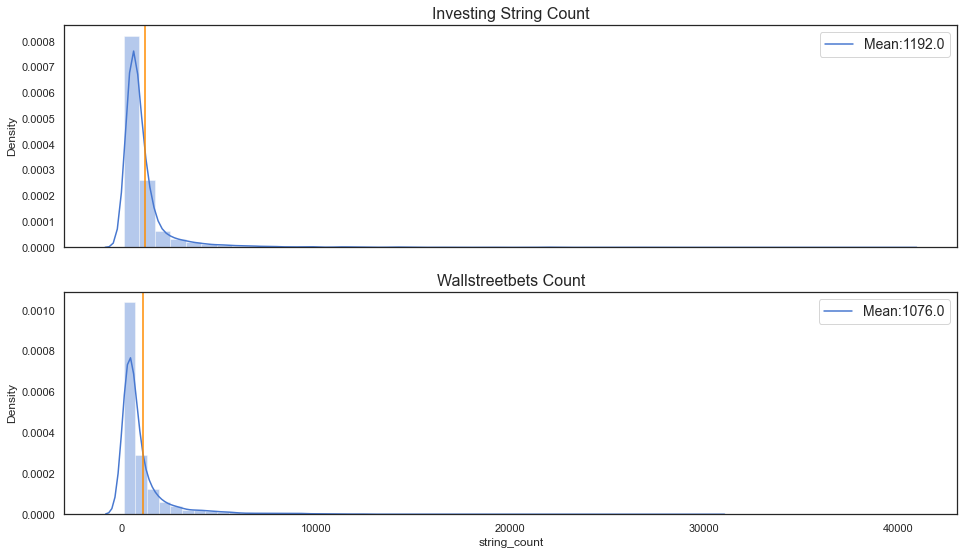

In [13]:
# Distribution of strings
ist = df[df['y']==0]['string_count']
wls = df[df['y']==1]['string_count']

sns.set(style="white", palette="muted", color_codes=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9), sharex=True)

# investing distplot
sns.distplot(ist, ax=ax1).axvline(ist.mean(), color='darkorange')
ax1.set_title('Investing String Count', fontsize=16)
ax1.legend({f'Mean:{round(ist.mean(),0)}':ist.mean()}, fontsize=14)

# wallstreetbets distplot
sns.distplot(wls, ax=ax2).axvline(wls.mean(), color='darkorange')
ax2.set_title('Wallstreetbets Count', fontsize=16)
ax2.legend({f'Mean:{round(wls.mean(),0)}':wls.mean()}, fontsize=14);

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


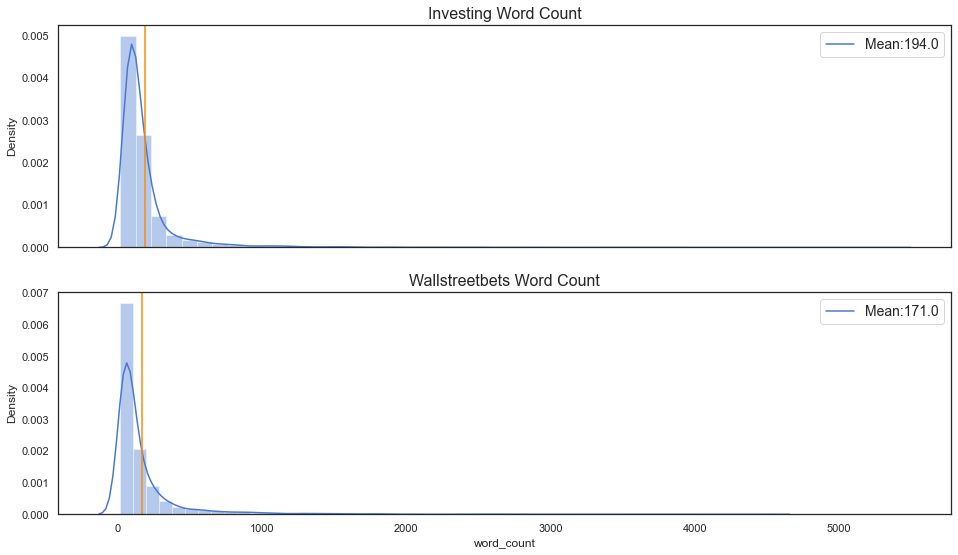

In [14]:
# Distribution of words
ist = df[df['y']==0]['word_count']
wls = df[df['y']==1]['word_count']

sns.set(style="white", palette="muted", color_codes=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9), sharex=True)

# investing distplot
sns.distplot(ist, ax=ax1).axvline(ist.mean(), color='darkorange')
ax1.set_title('Investing Word Count', fontsize=16)
ax1.legend({f'Mean:{round(ist.mean(),0)}':ist.mean()}, fontsize=14)

# wallstreetbets distplot
sns.distplot(wls, ax=ax2).axvline(wls.mean(), color='darkorange')
ax2.set_title('Wallstreetbets Word Count', fontsize=16)
ax2.legend({f'Mean:{round(wls.mean(),0)}':wls.mean()}, fontsize=14);

### Findings
The average word_count for investing subreddit posts is 194 words while the average word_count for Wallstreetbets subreddit posts is 171 words. Once again, both distributions are also skewed to the right. On average, investing subreddit posts are longer than Wallstreetbets subreddit posts.

### NLP

In [15]:
# Defining a Function to perform NLP

from logging import raiseExceptions


def text_processing(raw_text, method):

    leakage_words = ['http', 'www']

    # Step 1: Remove HTML
    review_text = BeautifulSoup(raw_text).get_text()
    
    # Step 2: Tokenizing - Remove punctuation and convert all text to lowercase
    tokenizer = RegexpTokenizer(r'\w+')
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    # Convert all text to lowercase
    words = letters_only.lower().split()
    
    # Step 3: Remove stopwords and leakage words
    words = [word for word in words if word not in stopwords.words('english')+leakage_words]
    
    # Step 4: Stem or lemmatize each word of the text
    if method == 'lemmatize':
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    elif method == 'stem':
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    else:
        raise Exception("No method found")
    
    # Step 5: Remove any additional stopwords and leakage words that might not have been removed in Step 3
    words = [word for word in words if word not in stopwords.words('english')+leakage_words]
    
    # Return the final string
    return ' '.join(words)

In [16]:
# Creating new df with a new column of cleaned text after performing Text Processing
cleaned_df = df.copy()
cleaned_df['lem_text'] = df['text'].apply(lambda x: text_processing(x,'lemmatize'))
cleaned_df['stem_text'] = df['text'].apply(lambda x: text_processing(x,'stem'))
cleaned_df.head()

,created_utc,word_count,text,y,string_count,lem_text,stem_text
0,1608335085,113,Why has SCHB been outperforming SWTSX a little...,0,643,schb outperforming swtsx little bit lately sch...,schb outperform swtsx littl bit late schb us b...
1,1608335945,73,Is Lithium Overpriced Is anything cheap I have...,0,426,lithium overpriced anything cheap wanting get ...,lithium overpr anyth cheap want get lithium we...
2,1608338046,97,Favorite Game Changer Technology Picks If QS c...,0,528,favorite game changer technology pick q get so...,favorit game changer technolog pick qs get sol...
3,1608339518,134,BFT Juicy looking Acquisition Hey Guys for onc...,0,1187,bft juicy looking acquisition hey guy ive done...,bft juici look acquisit hey guy ive done actua...
4,1608340295,230,Tesla Shares Hit Record After LastMinute Surge...,0,1462,tesla share hit record lastminute surge ahead ...,tesla share hit record lastminut surg ahead sa...


In [26]:
cleaned_df.to_csv('data_nlp.csv', index=False)

In [18]:
# Function to find the top 100 words from subreddits and visualize them

def top_words_plt(df,cat,name): 
    
    # interpret params：
    # df: text dataframe; 
    # cat: category of y: 0 -> investing; 1 -> wallstreetbets; 
    # name: name of text field

    r = df[df['y'] == cat][[name]]
    ct = 'investing' if cat==0 else 'wallstreetbets'
    md = 'lemmatized' if name=='lem_text' else 'stem'

    # instantialize CountVectorizer
    cvec = CountVectorizer(min_df = 2, stop_words='english')
   
    # Fit our vectorizer into posts from subreddits
    cvec.fit(r[name])

    # Total number of features (words) in posts from subreddits
    print(f'Number of {md} features '+'without stop words: {}'.format(len(cvec.get_feature_names_out())))

    # Transforming using our fitted cvec and converting the result to a DataFrame
    tf_words = pd.DataFrame(cvec.transform(r[name]).todense(),
                           columns=cvec.get_feature_names_out())

    # Finding the top 100 words that frequently appeared in the subreddits
    wds_top = pd.DataFrame(tf_words.sum(axis = 0).sort_values(ascending = False).head(100))

    # Filtering out the top 100 words/columns names
    top_wds = tf_words[wds_top.index]
    #print(f'Name of top 100 {md} features '+'without stop words: {}'.format(wds_top.index))

    # Visialize the findings
    f, (ax0, ax1) = plt.subplots(2, 1)
    f.set_size_inches(26, 20)
    f.tight_layout(pad=10)

    # Barplot of Top 20 Words
    wds_top.iloc[:21,:].plot(ax=ax0, kind='barh')
    ax0.set_title(f'Top 20 {md} Words from r/{ct}', fontsize=25)
    ax0.set_xlabel('Words', fontsize=15)
    ax0.set_ylabel('Count', fontsize=15)

    # Wordcloud of Top 100 Words
    wordcloud = WordCloud(background_color="white").generate(' '.join(top_wds))
    ax1.imshow(wordcloud, interpolation='bilinear')
    ax1.set_title(f'Top 100 {md} Word Cloud - r/{ct}', fontsize=25)
    ax1.axis("off")

    # return top features names
    return wds_top.index

Number of stem features without stop words: 10503
Number of lemmatized features without stop words: 13533


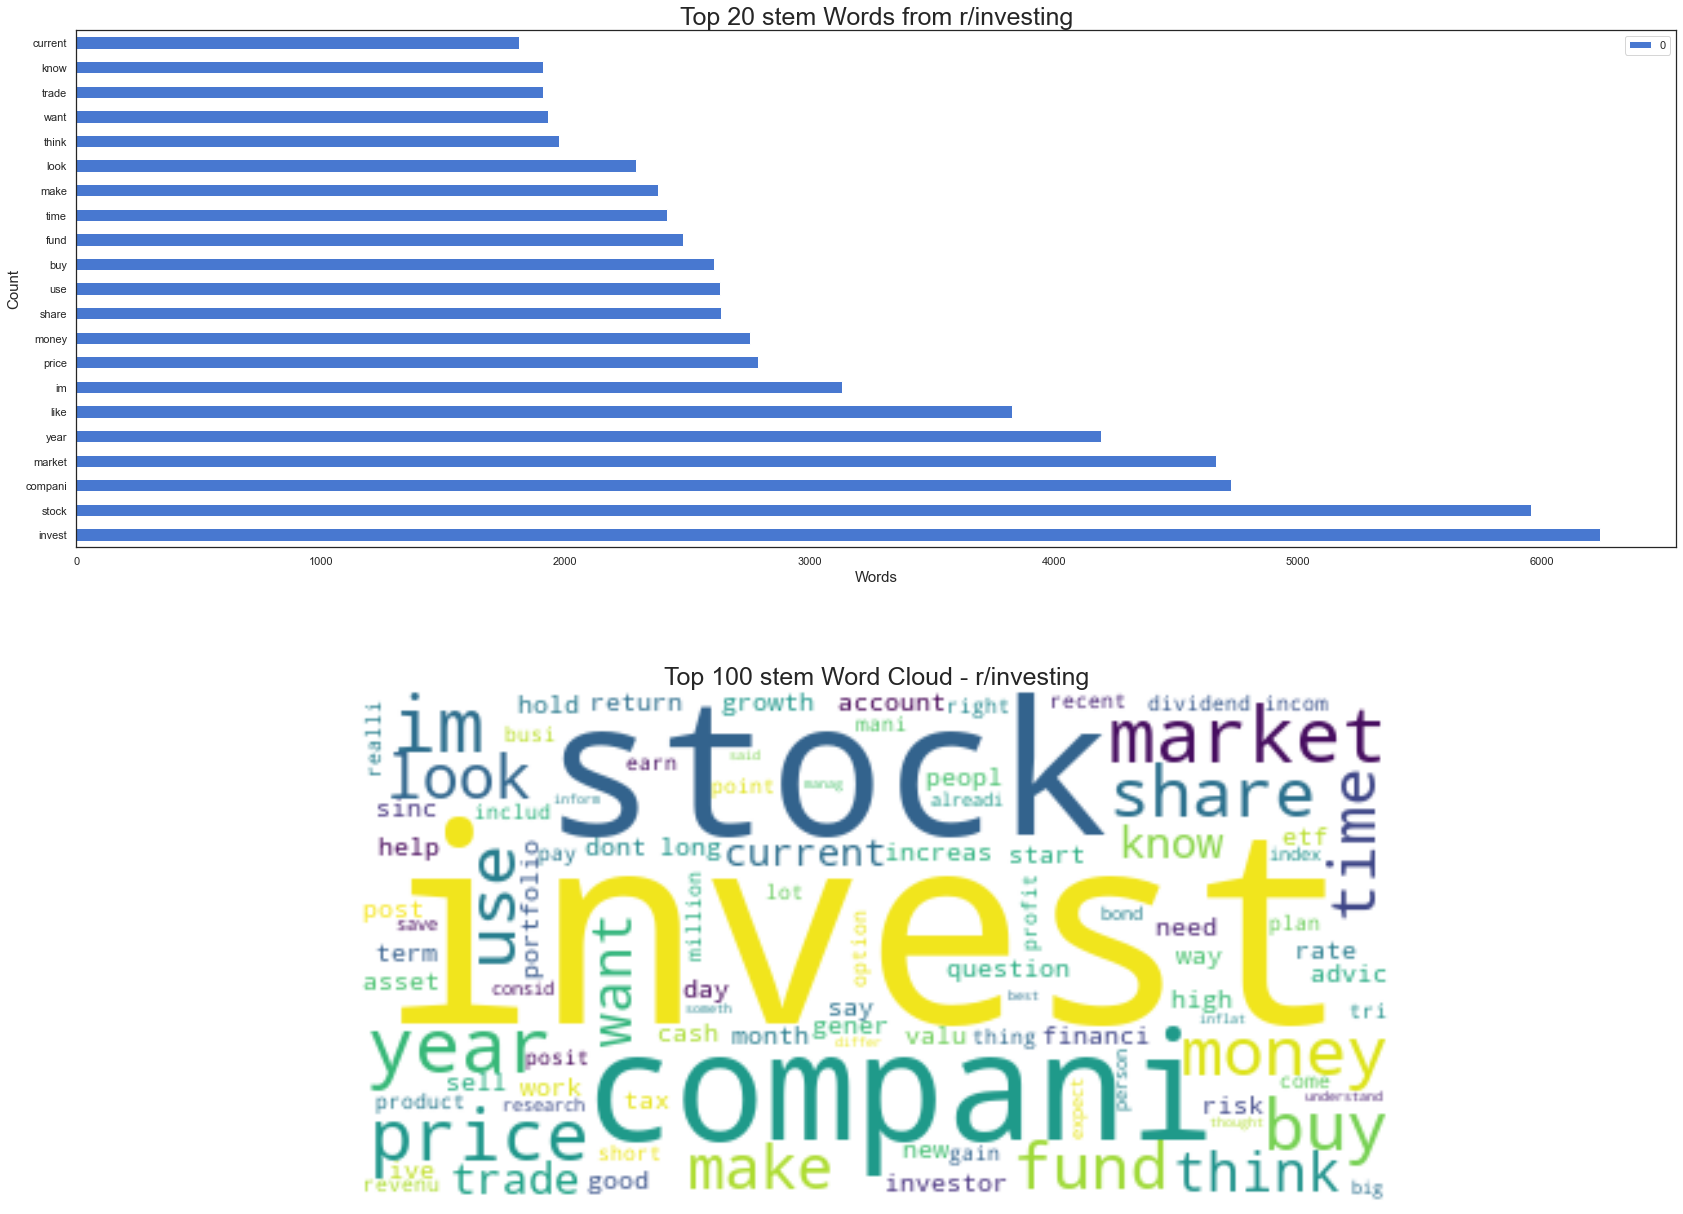

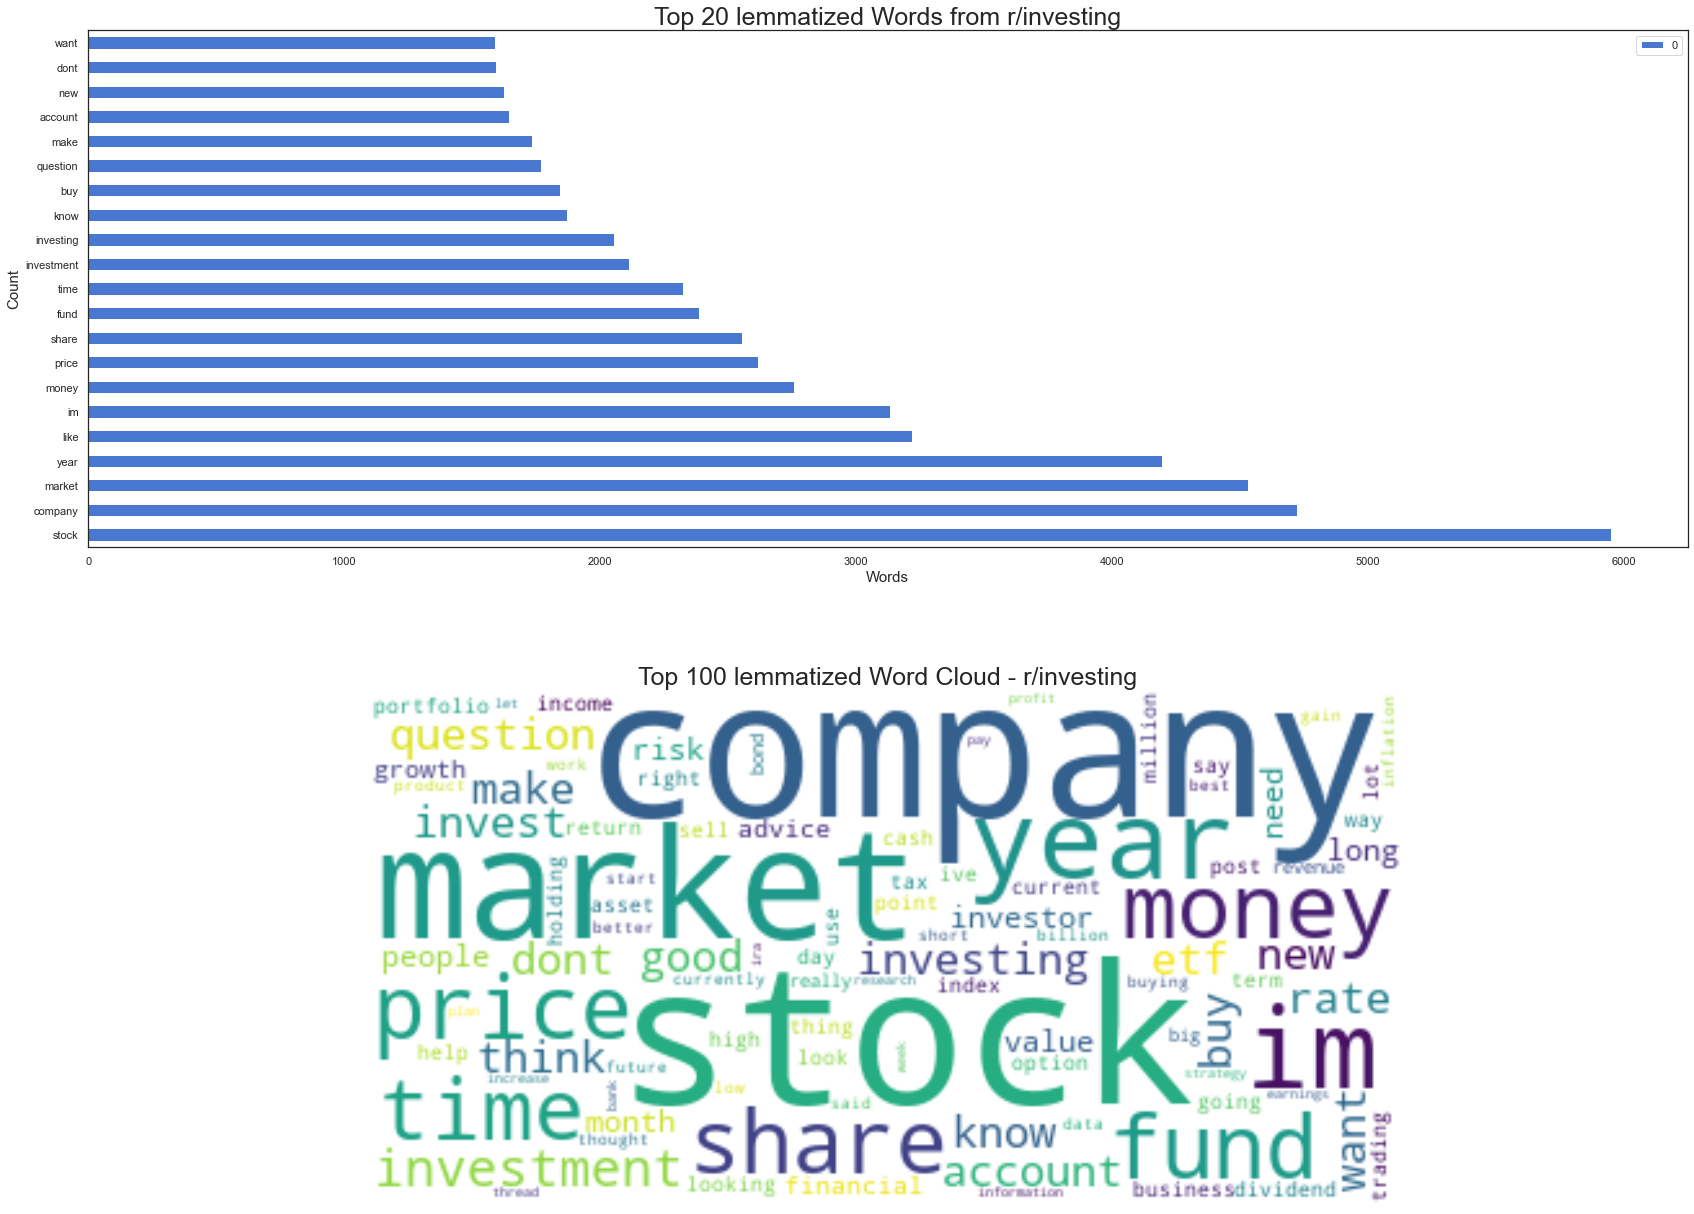

In [19]:
# Visialize top words/columns names for investing
stem_top_ist = top_words_plt(cleaned_df,0,'stem_text')
lemma_top_ist = top_words_plt(cleaned_df,0,'lem_text')

Number of stem features without stop words: 11609
Number of lemmatized features without stop words: 14783


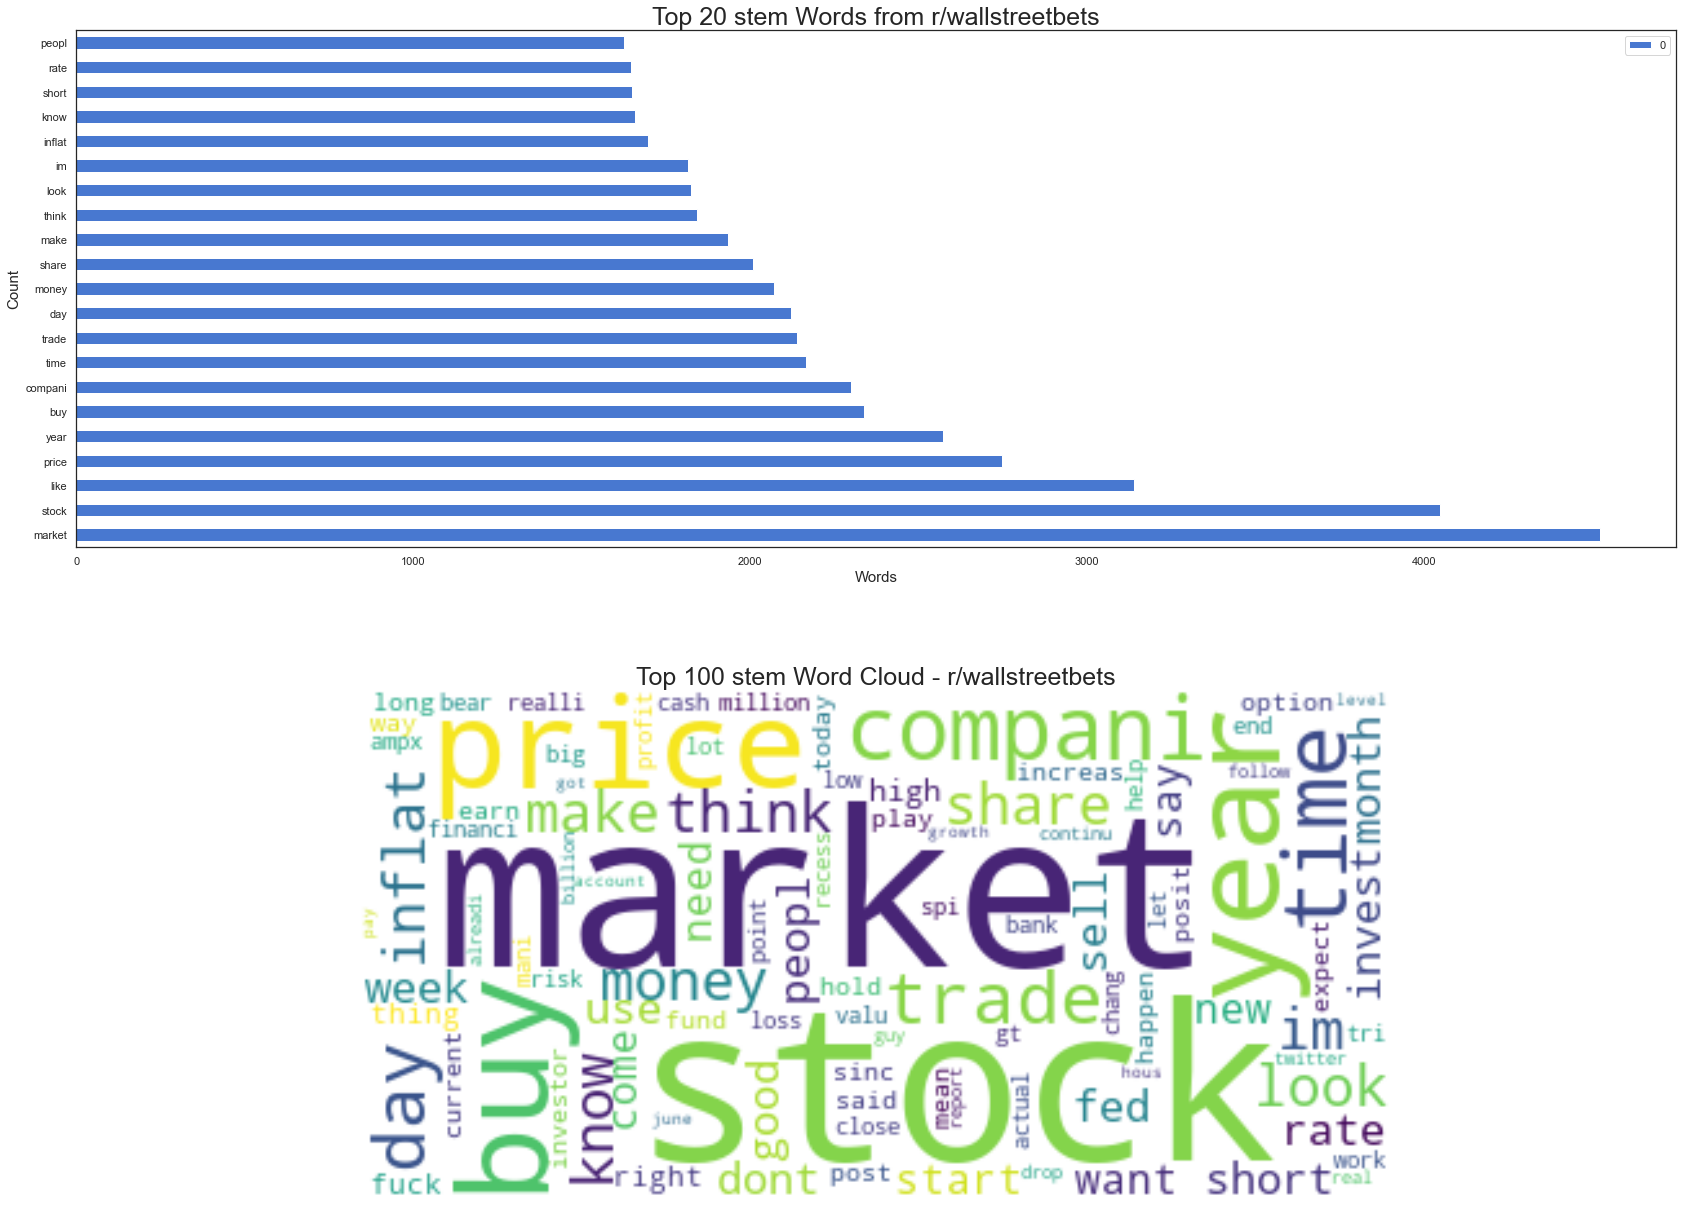

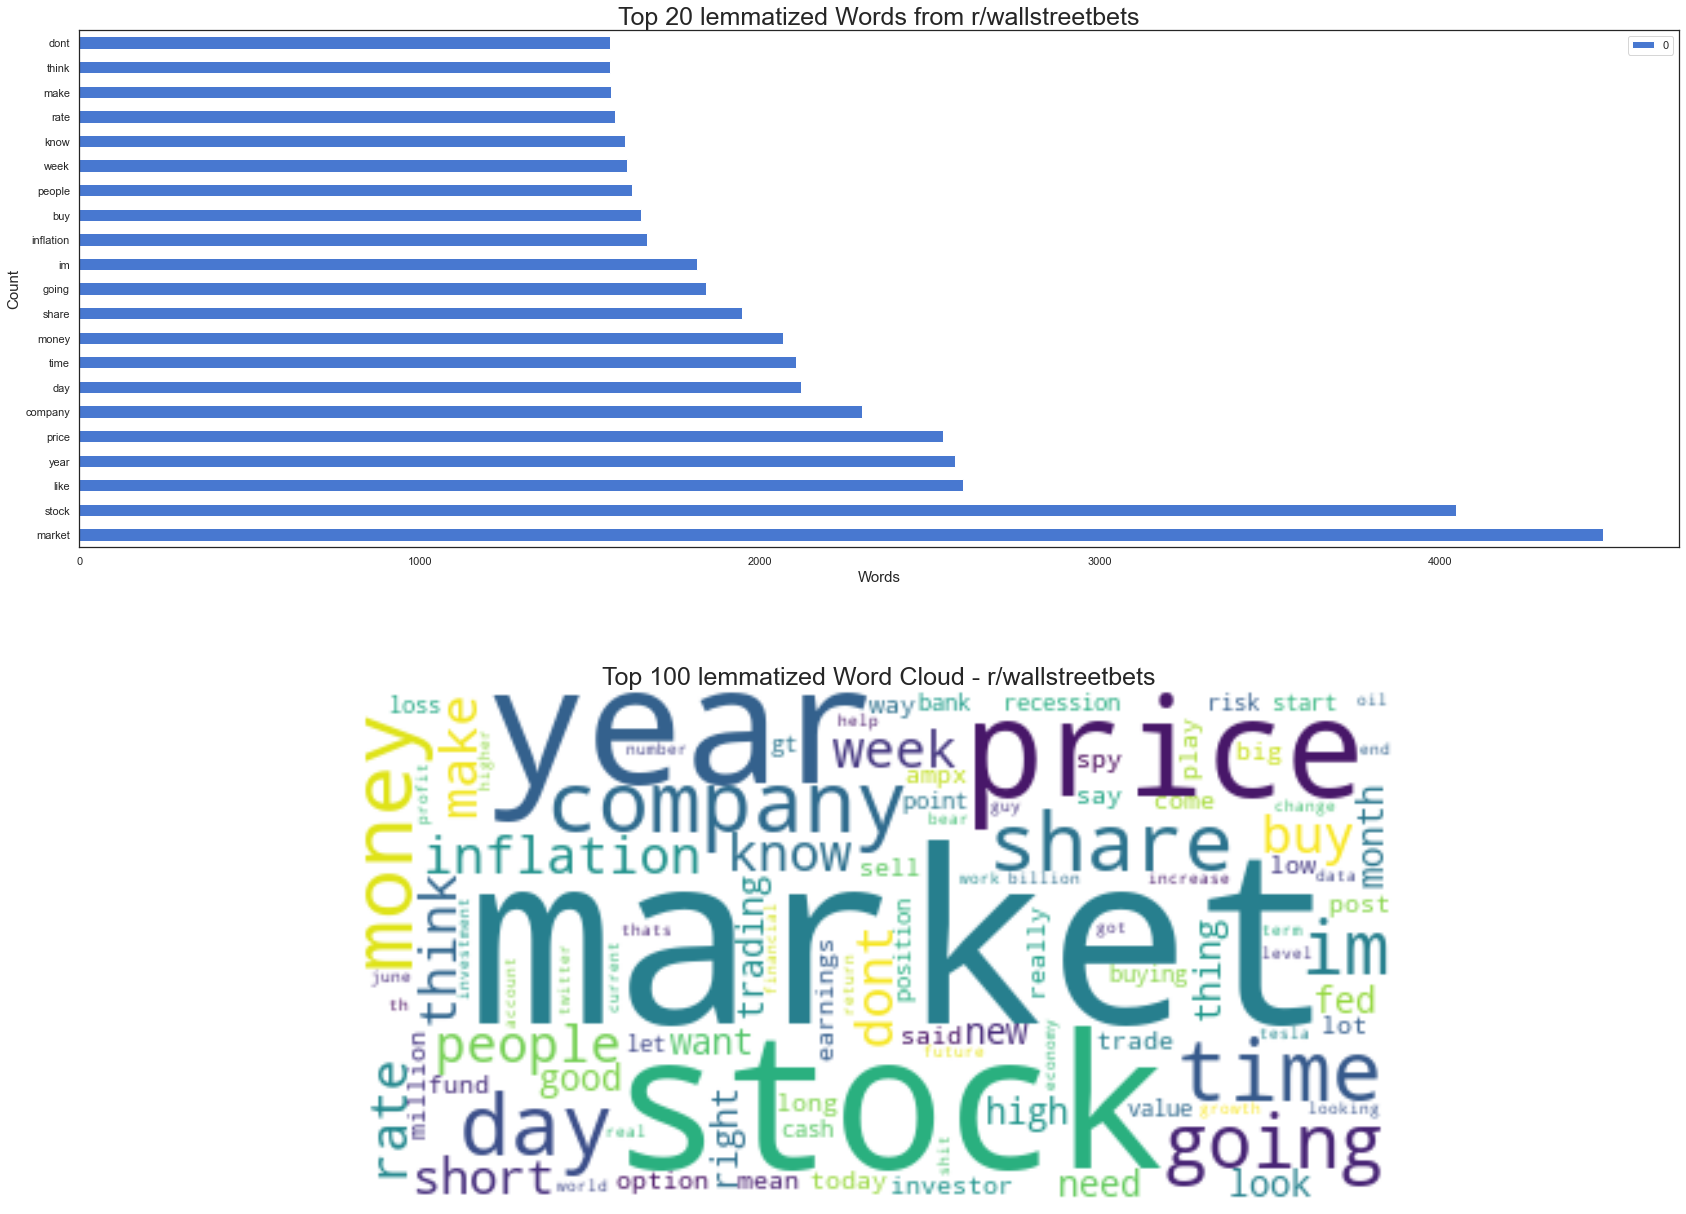

In [20]:
# top words/columns names for wsb
stem_top_wsb = top_words_plt(cleaned_df,1,'stem_text')
lemma_top_wsb = top_words_plt(cleaned_df,1,'lem_text')

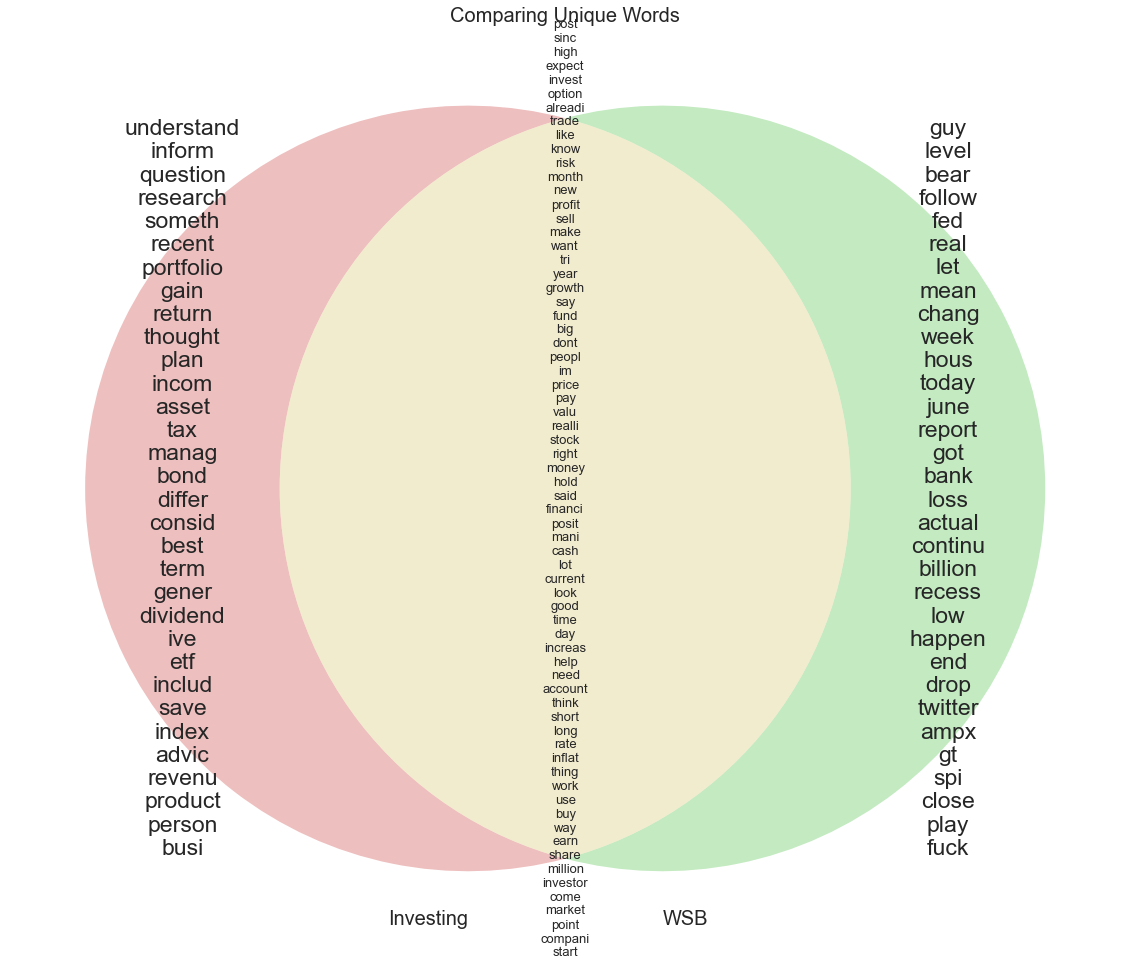

In [21]:
plt.figure(figsize=(20,20))
plt.title('Comparing Unique Words',fontsize=20)

set_a = set(stem_top_ist[:])
set_b = set(stem_top_wsb[:])

venn = venn2([set_a,set_b],set_labels=['Investing','WSB'])
venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(23)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(23)

In [22]:
len(set(stem_top_ist) - set(stem_top_wsb))

32

In [23]:
len(set(lemma_top_ist) - set(lemma_top_wsb))

30

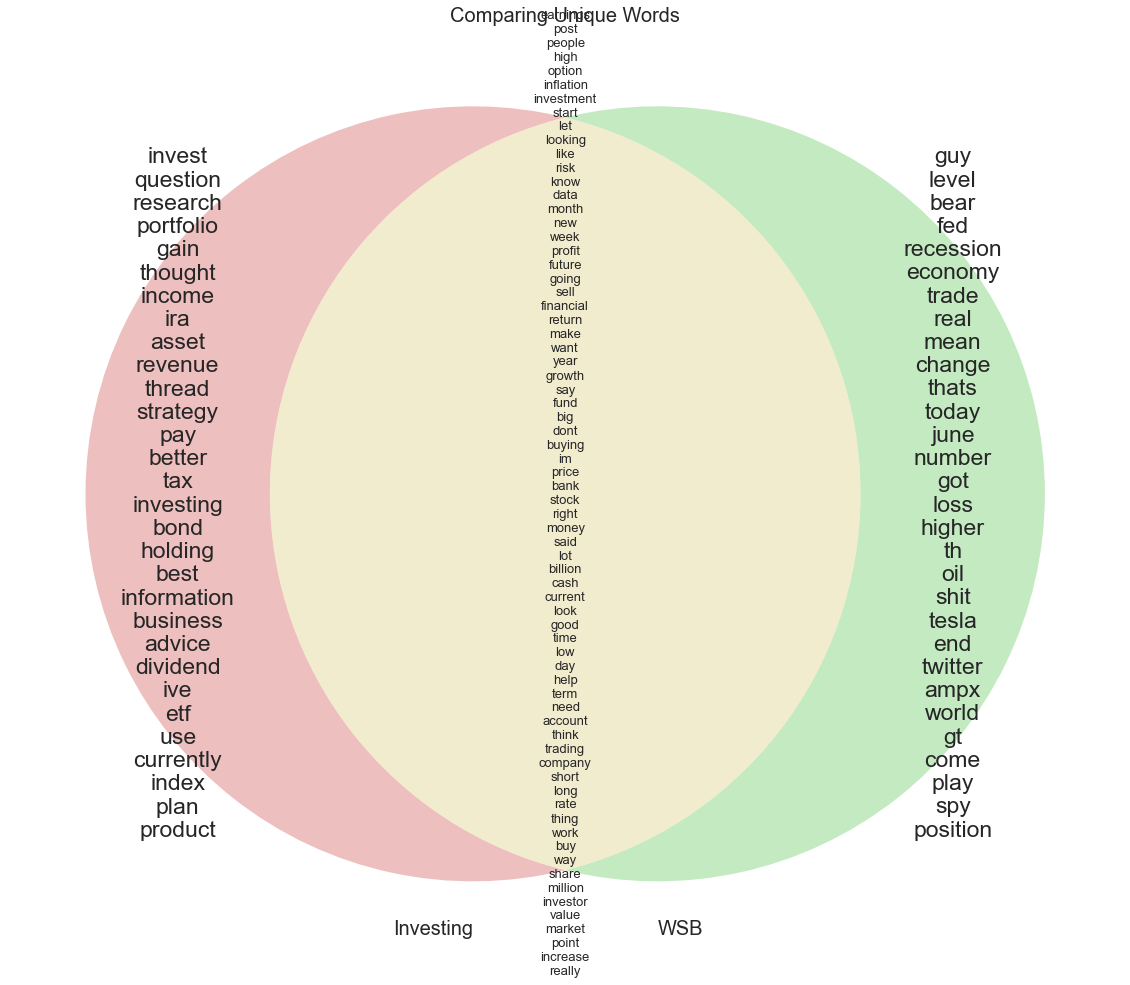

In [24]:
plt.figure(figsize=(20,20))
plt.title('Comparing Unique Words',fontsize=20)

set_a = set(lemma_top_ist)
set_b = set(lemma_top_wsb)

venn = venn2([set_a,set_b],set_labels=['Investing','WSB'])
venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(23)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(23)

plt.savefig('Comparing Unique Words.pdf', bbox_inches='tight')